# Spatial-DC: a robust deep learning-based method for deconvolution of spatial proteomics
The demo analysis workflow and source code for deconvolution of synthetic spatial proteomics data by Spatial-DC, is described below.

[![python >3.8.10](https://img.shields.io/badge/python-3.8.10-brightgreen)](https://www.python.org/)

<p align="center">
  <img width="100%" src=simulations.jpg>
</p>

<p align="center"><strong>The typical framework of generating synthetic spatial proteomics data. </strong></p>

## Here is a demo code on python envirment to the assessment of Spatial-DC on synthetic NSCLC data.

In [1]:
# Load necessary packages
import os
import sys
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr,spearmanr
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib as mat
from scipy import stats
# import cell2location
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import warnings
warnings.filterwarnings("ignore")

# plt.rcParams['font.size'] = 10
# plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['ps.fonttype'] = 42

In [2]:
# set the working directory
os.chdir("/aaa/zihanwu/yyyli2/project1_spatial_deconv/code_data_availability/Spatial_DC_V1")
dataset_dir = "datasets/NSCLC/synthetic_noise_levels"
scaler = MinMaxScaler(feature_range=(0, 1))

## Overview of reference data and spatial proteomics data.

In [3]:
# Overview the reference proteomics data
sc_adata = sc.read_h5ad(f"{dataset_dir}/reference_proteomics_noise/reference_noise0.h5ad")
print(f"Protein intensity: {sc_adata.to_df().iloc[0:4,0:4]}\n")
print(f"The number of cells: {sc_adata.obs['celltype'].value_counts()}\n")
print("The total cells and intersected proteins:", sc_adata.shape)

Protein intensity: pid             B2RQC6       D3YXK2       D3Z7P3       E9Q555
SampleID                                                     
Cell1     10199.681641  1206.335083  3252.627686  7920.826172
Cell2      7663.400879  1475.635010  4225.516602  7812.691895
Cell3     11032.712891  1869.883545  3676.055664  6762.318359
Cell4      8994.453125  1951.975586  3811.925049  5835.416992

The number of cells: celltype
C10     36
RAW     36
SVEC    36
Name: count, dtype: int64

The total cells and intersected proteins: (108, 1003)


In [4]:
ct_order = ["C10","RAW","SVEC"] # define the order of cell types

In [5]:
# Overview the spatial proteomics data (with spot size of 100 μm)
sp_adata = sc.read_h5ad(f"{dataset_dir}/spatial_proteomics_spotsize_noise/spatial_spotsize100_noise0.h5ad")
print(f"Protein intensity: {sp_adata.to_df().iloc[0:4,0:4]}\n")
# print(f"The number of spots: {sp_adata.obs['celltype'].value_counts()}\n")
print("The total spots and intersected proteins:", sp_adata.shape)

Protein intensity:           B2RQC6     D3YXK2    D3Z7P3     E9Q555
spot_1  0.795462   5.653947  1.296761   9.824759
spot_2  3.279686  13.582102  2.494954  26.243492
spot_3  1.628308   8.924311  2.072900  17.872507
spot_4  1.403659   7.396604  1.393854  12.178470

The total spots and intersected proteins: (1917, 1003)


In [6]:
sp_adata.uns["celltype_gd"]

,C10,RAW,SVEC
spot_1,0.000000,0.333333,0.666667
spot_2,0.000000,0.000000,1.000000
spot_3,0.000000,0.125000,0.875000
spot_4,0.000000,0.750000,0.250000
spot_5,0.250000,0.000000,0.750000
...,...,...,...
spot_1913,0.000000,0.000000,1.000000
spot_1914,0.000000,0.000000,1.000000
spot_1915,0.000000,0.000000,1.000000
spot_1916,0.333333,0.333333,0.333333


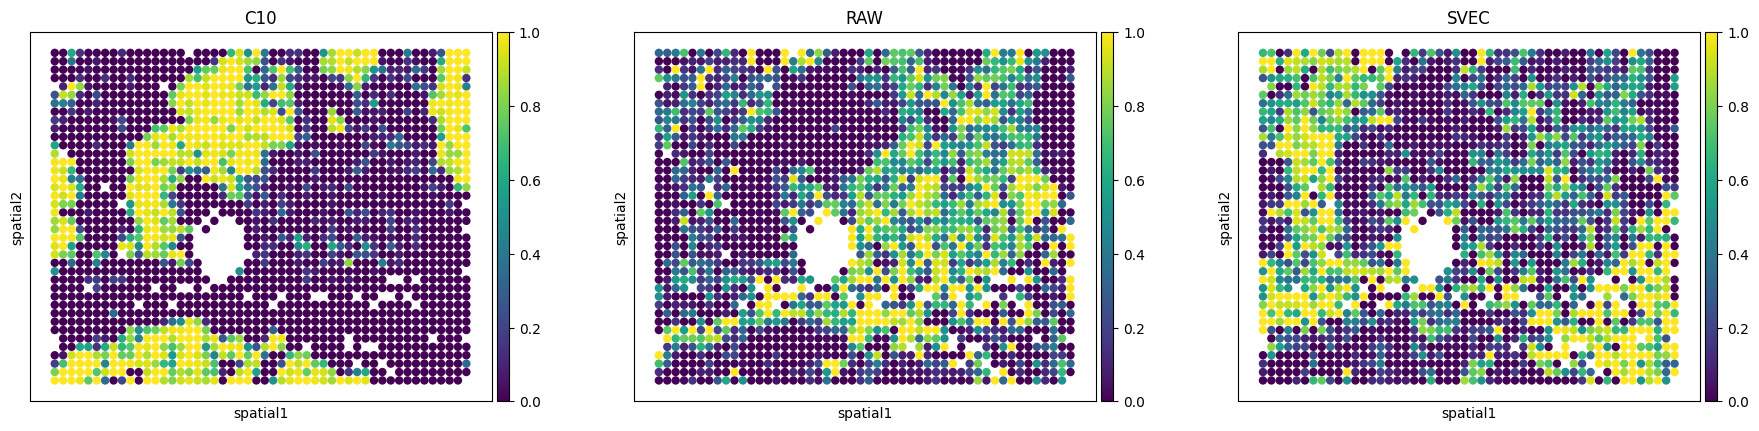

In [7]:
# Overview and visualization of the ground truth of each cell type
sp_adata.obs = sp_adata.uns["celltype_gd"]
sc.pl.spatial(sp_adata,spot_size=1,color=ct_order)

In [8]:
# Load Intersection of reference and spatial datasets
intersect = np.intersect1d(sc_adata.var_names, sp_adata.var_names)        
sp_adata = sp_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()

sc.pp.normalize_total(sc_adata)
sc.pp.normalize_total(sp_adata)

## Create deconvolution model and load trained DIS model

In [9]:
# Load Spatial-DC package
from Spatial_DC_beta import SpatialDC

In [10]:
# Load trained DIS model
model_path = f"trained_model/NSCLC/synthetic_noise_levels/model_epoch200_noise0.pt"

spatial_dc = SpatialDC(sc_adata=sc_adata, sp_adata=sp_adata, print_info=True) 
spatial_dc.load_distribution_model(load_model_path = model_path)
pred_sp_adata = spatial_dc.transfer_distribution_model()
# pred_sp_adata.uns["cellperc_initial"].to_csv(output_file_path + "_initial.csv")

In [11]:
pred_sp_adata.uns["cellperc_initial"].iloc[0:4,0:4] # Overview of the intermediate cell percentages

,C10,RAW,SVEC
spot_1,0.010724,0.020915,0.968361
spot_2,0.000000,0.000000,1.000000
spot_3,0.011867,0.000000,0.988133
spot_4,0.000000,1.000000,0.000000


In [12]:
# Traine the self-supvervised model
spatial_dc.setup_reconstruction_model(k_graph=30, epochs=200)
refined_sp_adata = spatial_dc.reconstruct()

  [Epoch   1] Loss: 26.13975
  [Epoch   2] Loss: 21.70615
  [Epoch   3] Loss: 18.55198
  [Epoch   4] Loss: 17.12035
  [Epoch   5] Loss: 16.44596
  [Epoch   6] Loss: 16.29426
  [Epoch   7] Loss: 15.78596
  [Epoch   8] Loss: 15.65378
  [Epoch   9] Loss: 15.46721
  [Epoch  10] Loss: 15.38306
  [Epoch  11] Loss: 15.09021
  [Epoch  12] Loss: 14.96540
  [Epoch  13] Loss: 14.84177
  [Epoch  14] Loss: 14.60172
  [Epoch  15] Loss: 14.46630
  [Epoch  16] Loss: 14.19939
  [Epoch  17] Loss: 14.02319
  [Epoch  18] Loss: 13.92860
  [Epoch  19] Loss: 13.74556
  [Epoch  20] Loss: 13.52844
  [Epoch  21] Loss: 13.33058
  [Epoch  22] Loss: 13.12799
  [Epoch  23] Loss: 12.89790
  [Epoch  24] Loss: 12.72787
  [Epoch  25] Loss: 12.52167
  [Epoch  26] Loss: 12.32118
  [Epoch  27] Loss: 12.09333
  [Epoch  28] Loss: 11.83667
  [Epoch  29] Loss: 11.61478
  [Epoch  30] Loss: 11.44438
  [Epoch  31] Loss: 11.19541
  [Epoch  32] Loss: 10.92797
  [Epoch  33] Loss: 10.62620
  [Epoch  34] Loss: 10.42605
  [Epoch  35] 

In [14]:
# print the refined cell-type composition
pred_ct = pred_sp_adata[sp_adata.obs.index].uns["cellperc_reconstruct"][ct_order]
gd_ct = sp_adata.uns["celltype_gd"][ct_order]
print("Here is the predicted cell-type composition:")
print(pred_ct.iloc[0:10,0:4])
print("\n")
print("Here is the ground truth cell-type composition:")
print(gd_ct.iloc[0:10,0:4])

Here is the predicted cell-type composition:
              C10       RAW      SVEC
spot_1   0.000000  0.000000  1.000000
spot_2   0.000000  0.000000  1.000000
spot_3   0.000000  0.000000  1.000000
spot_4   0.000000  1.000000  0.000000
spot_5   0.220364  0.000000  0.779636
spot_6   0.558717  0.000000  0.441283
spot_7   0.116525  0.261053  0.622422
spot_8   0.000000  0.000000  1.000000
spot_9   0.000000  1.000000  0.000000
spot_10  0.000000  0.000000  1.000000


Here is the ground truth cell-type composition:
              C10       RAW      SVEC
spot_1   0.000000  0.333333  0.666667
spot_2   0.000000  0.000000  1.000000
spot_3   0.000000  0.125000  0.875000
spot_4   0.000000  0.750000  0.250000
spot_5   0.250000  0.000000  0.750000
spot_6   0.375000  0.250000  0.375000
spot_7   0.000000  0.333333  0.666667
spot_8   0.166667  0.250000  0.583333
spot_9   0.083333  0.666667  0.250000
spot_10  0.000000  0.125000  0.875000


Here is the ground truth cell-type composition


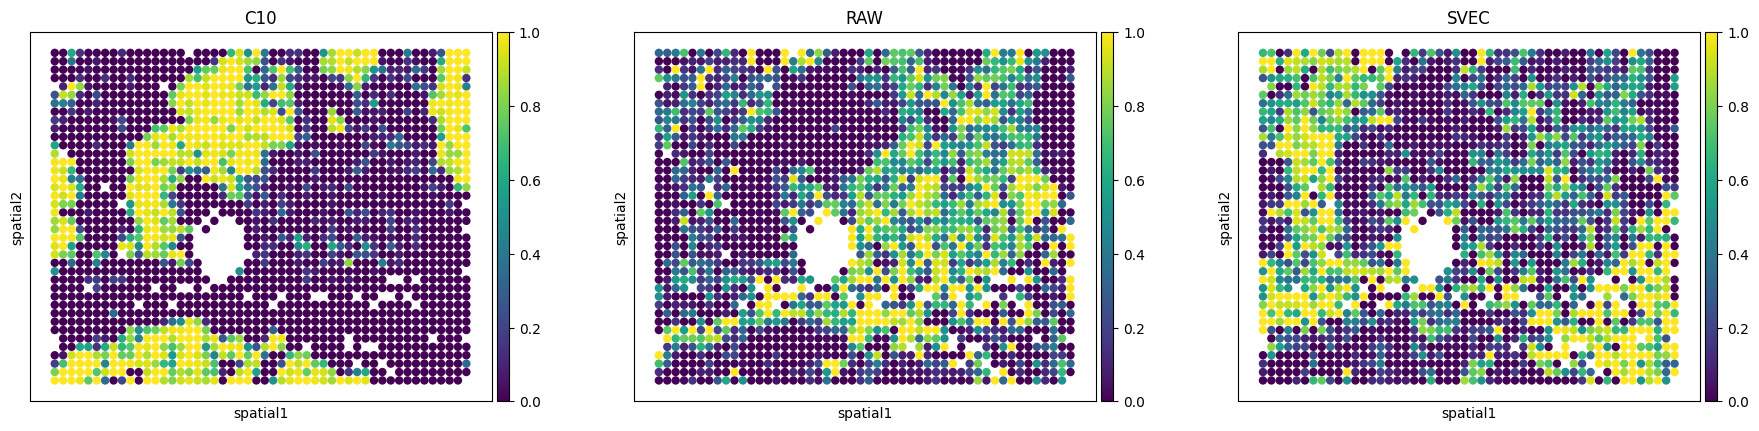

Here is the predicted cell-type composition


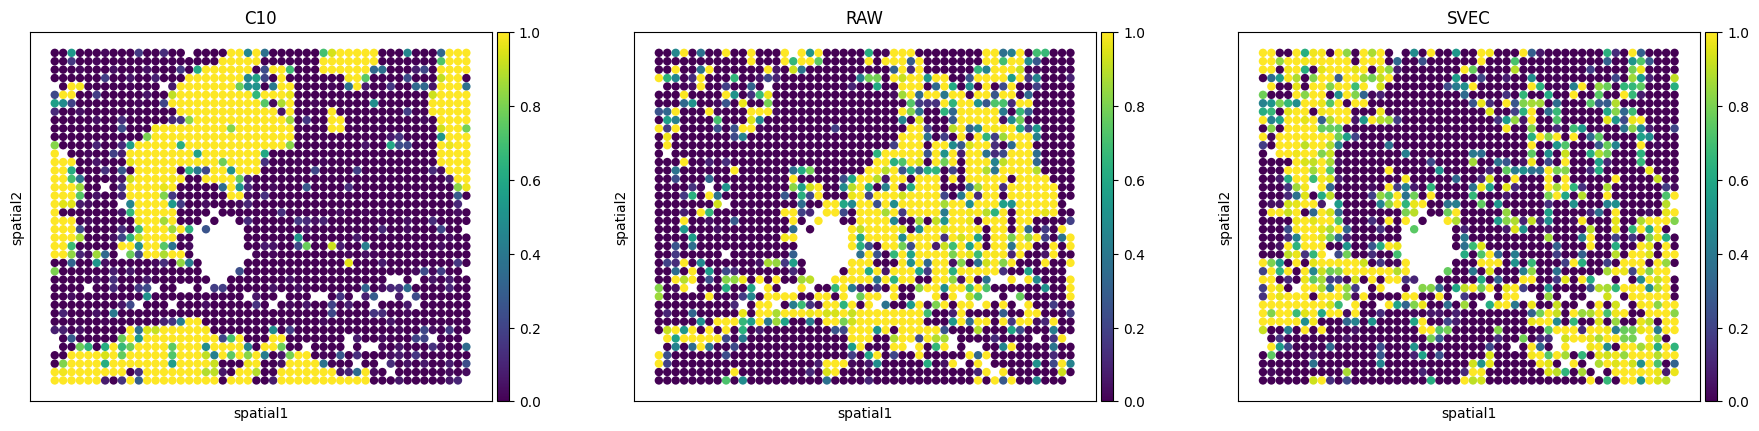

In [15]:
# Plot the distribution of predicted cell-type composition
print("Here is the ground truth cell-type composition")
sp_adata.obs = gd_ct[ct_order]
sc.pl.spatial(sp_adata,spot_size=1,color=ct_order,vmin=0,vmax=1)


sp_adata.obs = pred_ct[ct_order]
print("Here is the predicted cell-type composition")
sc.pl.spatial(sp_adata,spot_size=1,color=ct_order,vmin=0,vmax=1)



In [29]:
from scipy.stats import pearsonr, spearmanr, linregress
 
# Initialize lists to store results
results = []
 
def CCCscore(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    rho = np.corrcoef(x, y)[0][1]
    sd_x = np.std(x)
    sd_y = np.std(y)
    numerator = 2 * rho * sd_x * sd_y
    denominator = sd_x ** 2 + sd_y ** 2 + (x_mean - y_mean) ** 2
    ccc = numerator / denominator
    return ccc
 
# Calculate metrics for each cell type
for ct in ct_order:
    
    pcc = pearsonr(gd_ct[ct], pred_ct[ct])[0]        
    rmse = np.sqrt(np.mean((gd_ct[ct] - pred_ct[ct]) ** 2))        
    spcc = spearmanr(gd_ct[ct], pred_ct[ct])[0]    
    ccc = CCCscore(gd_ct[ct], pred_ct[ct])
    
    results.append({
        'cell type': ct,
        'PCC': pcc,
        'RMSE': rmse,
        'SPCC': spcc, 
        'CCC': ccc
    })
 
df_results = pd.DataFrame(results)
 
# Print the DataFrame
print("Performance evaluation of Spatial-DC:")
print(df_results)
 
# Calculate averages and print them
avg_metrics = df_results[['PCC', 'RMSE', 'SPCC', 'CCC']].mean()
print("\nThe average of the four metrics are:")
print(avg_metrics)

Performance evaluation of Spatial-DC:
  cell type       PCC      RMSE      SPCC       CCC
0       C10  0.981575  0.086093  0.838099  0.978843
1       RAW  0.951249  0.151455  0.930636  0.927122
2      SVEC  0.946947  0.146266  0.904661  0.932075

The average of the four metrics are:
PCC     0.959924
RMSE    0.127938
SPCC    0.891132
CCC     0.946013
dtype: float64


## Obtain the reconstructed spatially and cell-type resolved proteomics proteins

## Assessment of reconstructing cell-type proteomic profiles by Spatial-DC from representative synthetic NSCLC data